In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import transit

I first read the data obtained with the Keck telescope into the frame data

In [18]:
newdata = pd.read_table('Keckdata.txt', skiprows=[0, 2], sep='\s+')

And I select the three important variables, with the option to add an error in quadrature

In [19]:
bjd = np.array(newdata['JD-2.44e6'], 'd')
rvs = np.array(newdata['mnvel'], 'd')
rverr = np.array(newdata['errvel'], 'd')
additionalerr = 0.0

Now I use the orbital ephemeris obtained from the transits to define the orbital phases, and I also define a new zero point for the BJD timestamps

In [20]:
period = 0.6892099
tc = 2454953.1910
tc = tc-2440000.0

phasesaux = (bjd-tc)/period
phases, orbit = np.modf(phasesaux)

phases = phases
bjdlv = np.mean(bjd)
bjdrest, bjdint = np.modf(bjdlv)

phi0 = (bjdint-tc)/period
aux, phi0 = phi0-np.modf(phi0)

shortbjd = bjd-bjdint

Now I define a function that calculates the log of the likelihood for the fit

In [21]:
def threeperiodmodel(theta, phases, shortbjd):
    K, a, Amp, Phi, Per, Amp2, Phi2, Per2, Amp3, Phi3, Per3, sigma = theta
        
    return (-K*np.sin(2.0*np.pi*phases) + a + Amp*np.sin(2.0*np.pi*(shortbjd-Phi)/Per)
   + Amp2*np.sin(2.0*np.pi*(shortbjd-Phi2)/Per2) + Amp3*np.sin(2.0*np.pi*(shortbjd-Phi3)/Per3))

In [22]:
def lnlike(theta, phases, shortbjd, rvs, error):
    "Model to fit a sinusoid to the RV data"
    K, a, Amp, Phi, Per, Amp2, Phi2, Per2, Amp3, Phi3, Per3, sigma = theta

    theoRV = threeperiodmodel(theta, phases, shortbjd)
    inv_sigma2 = 1.0/(error**2 + sigma**2)

    return -0.5*(np.sum((theoRV-rvs)**2*inv_sigma2 - np.log(inv_sigma2)))

In [23]:
def lnprior(theta):
    K, a, Amp, Phi, Per, Amp2, Phi2, Per2, Amp3, Phi3, Per3, sigma = theta

    if ((20.0 < Per < 40.0) and (13.0 <= Per2 <20.0) and (6.0 <= Per3 <10.0) and(0 <= sigma) 
        and (0 <= Amp) and (0 <= Amp2) and (0 <= Amp3) and (0.0 <= Phi <= Per) and (0.0 <= Phi2 <= Per2) 
        and(0.0 <= Phi3 <= Per3)):
        return 0.0
    return -np.inf

In [24]:
def lnprob(theta, phases, shortbjd, rvs, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, phases, shortbjd, rvs, error)

And I obtain the best fit parameters, their uncertainties, and I plot the observations and the model

In [25]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [4.0, 8.0, 5.0, 10.0, 28.0, 8.0, 5.0, 15.5, 5.0, 3.0, 8.5, 1.5], 
                     args=(phases, shortbjd, rvs, rverr), tol=0.01, options={'disp': True, 'maxiter':100000}, method='BFGS')
K_ml, a_ml, Amp_ml, Phi_ml, Per_ml, Amp2_ml, Phi2_ml, Per2_ml, Amp3_ml, Phi3_ml, Per3_ml, sigma_ml = result["x"]
error = np.sqrt(rverr**2+ 0.0*sigma_ml**2)

Optimization terminated successfully.
         Current function value: 32.822940
         Iterations: 34
         Function evaluations: 666
         Gradient evaluations: 47


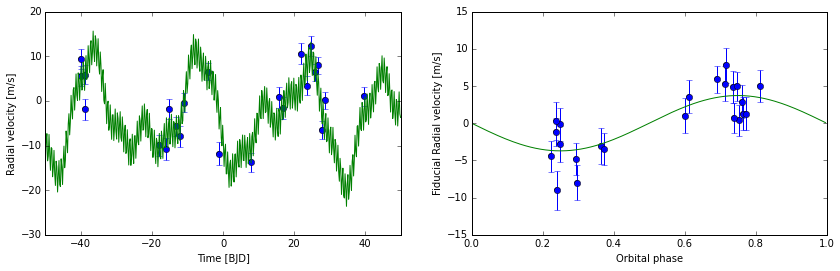

In [26]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(shortbjd, rvs)
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')
plt.xlim([-50, 50]) 
ax.set_xlabel('Time [BJD]')
ax.set_ylabel('Radial velocity [m/s]')

theoRV = (-K_ml*np.sin(2.0*np.pi*phases) + a_ml + Amp_ml*np.sin(2.0*np.pi*(shortbjd-Phi_ml)/Per_ml)
   + Amp2_ml*np.sin(2.0*np.pi*(shortbjd-Phi2_ml)/Per2_ml) + Amp3_ml*np.sin(2.0*np.pi*(shortbjd-Phi3_ml)/Per3_ml))
    
chi2= np.sum( ((theoRV-rvs)/error)**2)

newbjd = np.linspace(-50, 50, 500)
newx = (newbjd/period) + phi0
newphases, orbit = np.modf(newx)

newRVplot = (-K_ml*np.sin(2.0*np.pi*newphases) + a_ml + Amp_ml*np.sin(2.0*np.pi*(newbjd-Phi_ml)/Per_ml)
   + Amp2_ml*np.sin(2.0*np.pi*(newbjd-Phi2_ml)/Per2_ml) + Amp3_ml*np.sin(2.0*np.pi*(newbjd-Phi3_ml)/Per3_ml))
    

plt.plot(newbjd, newRVplot)


ax = fig.add_subplot(1,2,2)

plottheoRV = (a_ml + Amp_ml*np.sin(2.0*np.pi*(shortbjd-Phi_ml)/Per_ml)
   + Amp2_ml*np.sin(2.0*np.pi*(shortbjd-Phi2_ml)/Per2_ml) + Amp3_ml*np.sin(2.0*np.pi*(shortbjd-Phi3_ml)/Per3_ml))
    

ax.scatter(phases, rvs-plottheoRV)
ax.errorbar(phases, rvs-plottheoRV, yerr=error, fmt='o')
plt.xlim([-0, 1]) 
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Fiducial Radial velocity [m/s]')


sort_index = np.argsort(newphases)
ytheo = -K_ml*np.sin(2.0*np.pi*newphases)

plt.plot(newphases[sort_index], ytheo[sort_index])

With the best fit solution, it is time to run and MCMC routine to estimate the uncertainties on the parameters

In [27]:
ndim, nwalkers = 12, 100
pos = [result["x"]*(1+5e-2*np.random.randn(ndim)) for i in range(nwalkers)]

In [28]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(phases, shortbjd, rvs, rverr))
sampler.run_mcmc(pos, 50000)

(array([[  2.80202193,  -0.15875478,   5.52391124, ...,   2.31372402,
           9.75489081,   6.38147003],
        [  3.64873785,  -2.51972647,   5.96940195, ...,   1.68852276,
           6.2264798 ,   2.35641637],
        [  6.03909751,  -4.4039059 ,   6.55596011, ...,   7.08112428,
           8.18837065,   3.98165341],
        ..., 
        [  4.01047039,  -4.58492482,   9.52081821, ...,   8.72754155,
           9.80503058,   6.10669241],
        [  4.26205035,  -4.54842597,   8.22586798, ...,   7.62181302,
           7.96047777,   3.56904348],
        [  4.06717555,  -2.62541224,  11.48757945, ...,   7.18392393,
           8.40122586,   3.72225024]]),
 array([-53.49477624, -43.61426149, -42.55822485, -45.08008646,
        -43.24405107, -43.94821211, -38.67936101, -39.1978513 ,
        -41.78534879, -47.5434148 , -41.25366279, -40.23656912,
        -40.5601211 , -48.47484113, -38.88792327, -37.62362817,
        -43.29392779, -38.62277139, -44.27996887, -40.10593707,
        -45.0990

In [29]:
samples = sampler.chain[:, 5000:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

Now I plot the results in a triangle plot 

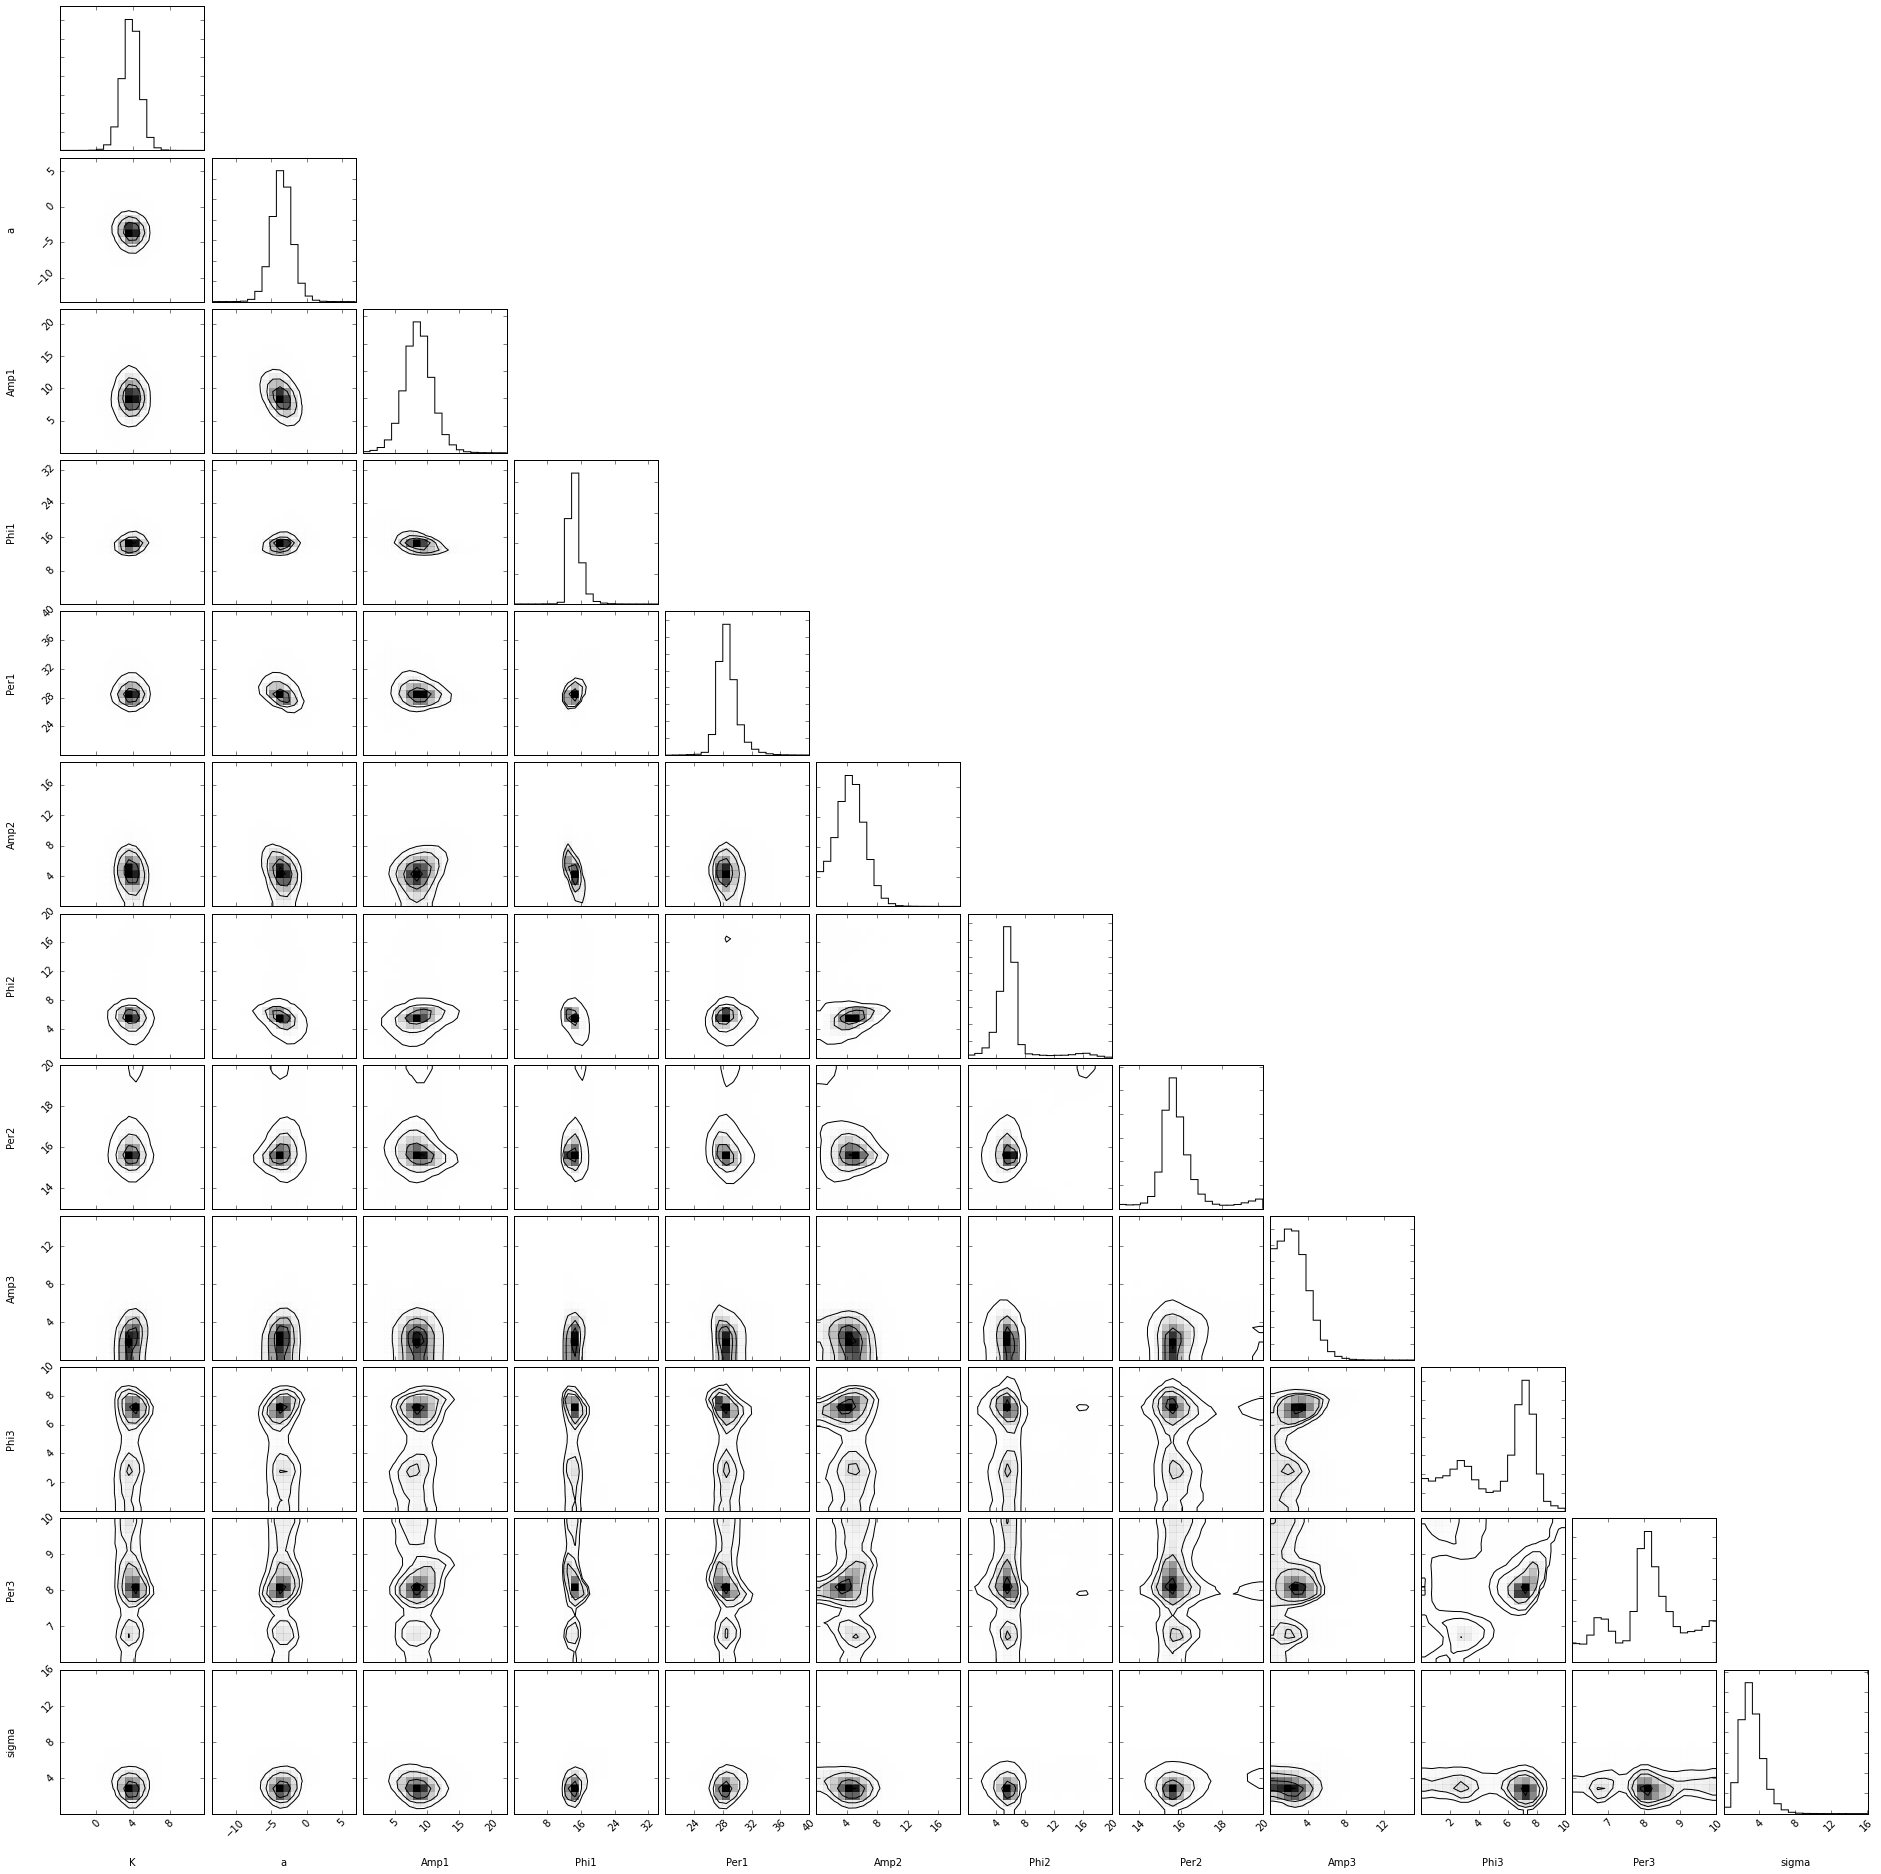

In [30]:
import triangle
fig = triangle.corner(samples, labels=["K", "a", "Amp1", "Phi1", "Per1",  "Amp2", "Phi2", "Per2",
             "Amp3", "Phi3", "Per3", "sigma"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [31]:
(K_mcmc, a_mcmc, Amp_mcmc, Phi_mcmc, Per_mcmc, Amp2_mcmc, Phi2_mcmc, Per2_mcmc, Amp3_mcmc, Phi3_mcmc, Per3_mcmc,
 sigma_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [32]:
print('K value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(K_mcmc[0],K_mcmc[1], K_mcmc[2] ))
print('Chi2 value {0:3.2f} with {1:1.0f} points and 12 parameters' .format(chi2, len(rvs)))
print('First period {0:3.2f} + {1:3.2f} - {1:3.2f}'.format(Per_mcmc[0], Per_mcmc[1], Per_mcmc[2]))
print('Second period {0:3.2f} + {1:3.2f} - {1:3.2f}'.format(Per2_mcmc[0], Per2_mcmc[1], Per2_mcmc[2]))
print('Third period {0:3.2f} + {1:3.2f} - {1:3.2f}'.format(Per3_mcmc[0], Per3_mcmc[1], Per3_mcmc[2]))

K value 3.80 +0.91 - 0.91
Chi2 value 29.95 with 23 points and 12 parameters
First period 28.52 + 1.38 - 1.38
Second period 15.71 + 0.84 - 0.84
Third period 8.12 + 1.02 - 1.02
